In [1]:
# Note: this training notebook has itself been derived from the nice example at
# https://github.com/warmspringwinds/pytorch-segmentation-detection/
# under recipes/pascal_voc/segmentation/resnet_34_8s_train.ipynb

# This script also uses the network model in
# warmspringwinds/pytorch-segmentation-detection/

%matplotlib inline
import sys, os
sys.path.insert(0, '../../pytorch-segmentation-detection/vision/')
sys.path.append('../../pytorch-segmentation-detection/')

# Choose GPU
os.environ["CUDA_VISIBLE_DEVICES"] = '0'


import torch
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim

import numpy as np

import pytorch_segmentation_detection.models.fcn as fcns
import pytorch_segmentation_detection.models.resnet_dilated as resnet_dilated
from pytorch_segmentation_detection.transforms import (ComposeJoint,
                                                       RandomHorizontalFlipJoint,
                                                       RandomScaleJoint,
                                                       CropOrPad,
                                                       ResizeAspectRatioPreserve,
                                                       RandomCropJoint,
                                                       Split2D)

In [2]:
sys.path.append("../dataset")
from spartan_dataset_masked import SpartanDataset
trainset = SpartanDataset()

# Note: in order to batch size larger than 1,
# appears that the tensor sizes of matches and non_matches
# will have to match across the batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=10, drop_last=True)


# ### massively important parameter ###
# set descriptor dimensionality here!!
# should maybe move this somewhere that stands out more
descriptor_dimensionality = 3

logs_root_path:  /home/manuelli/code/data_volume/10_scenes_drill_long
scenes:  ['06_drill_long_downsampled', '10_drill_long_downsampled', '13_drill_long_downsampled', '08_drill_long_downsampled', '05_drill_long_downsampled', '12_drill_long_downsampled', '09_drill_long_downsampled', '04_drill_long_downsampled', '11_drill_long_downsampled', '07_drill_long_downsampled', '14_background']
Using SpartanDataset with:
   - number of scenes: 10
   - total images:     1977


<IPython.core.display.Javascript object>


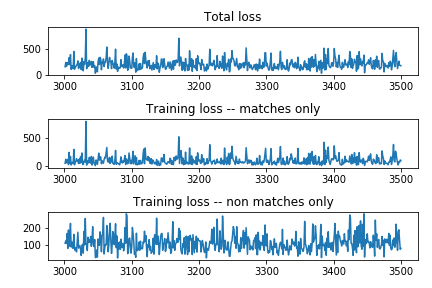

In [3]:
%matplotlib notebook
from matplotlib import pyplot as plt

# Create the training plot
loss_current_iteration = 0
loss_history = []
match_loss_history = []
non_match_loss_history = []
loss_iteration_number_history = []

f, (loss_axis, match_loss_axis, non_match_loss_axis) = plt.subplots(3, 1)

loss_axis.plot(loss_iteration_number_history, loss_history)
loss_axis.set_title('Total loss')
match_loss_axis.plot(loss_iteration_number_history, match_loss_history)
match_loss_axis.set_title('Training loss -- matches only')
non_match_loss_axis.plot(loss_iteration_number_history, non_match_loss_history)
non_match_loss_axis.set_title('Training loss -- non matches only')

plt.tight_layout()

In [4]:
fcn = resnet_dilated.Resnet34_8s(num_classes=descriptor_dimensionality)
fcn.cuda()
fcn.train()

sys.path.append("../loss_functions")
from pixelwise_contrastive_loss import PixelwiseContrastiveLoss
pixelwise_contrastive_loss = PixelwiseContrastiveLoss()

# note the lr specified here gets overwritten inside
# adjust_learning_rate
optimizer = optim.Adam(fcn.parameters(), lr=0.0001, weight_decay=0.0001)

load_previous = None
#load_previous = 'trained_models/debug_3d/dense_resnet_34_8s_04400.pth'
if load_previous is not None:
    print "loading", load_previous
    fcn.load_state_dict(torch.load(load_previous))
    optimizer.load_state_dict(torch.load(load_previous+".optim"))
    fcn.cuda()
    fcn.train()
    loss_current_iteration = int(load_previous.split('.pth')[0][-5:])
    print loss_current_iteration
    

def adjust_learning_rate(optimizer, iteration):
    """Pete: this also currently effectively stops training via an error
    since at max_iterations+1, it tries to raise a negative number to a fractional power"""
#     max_iteration = 10000.0
#     multiplier = (1.0 - (iteration / max_iteration)) ** (0.9)
#     lr = 0.00001 * multiplier
    if loss_current_iteration % 500 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr']*0.9
            
def save_net(iteration):
    folder_to_save = os.path.join(os.getcwd(),'trained_models/10_drill_long_'+str(descriptor_dimensionality)+'d/')
    os.system("mkdir -p "+folder_to_save)
    net_to_save = 'dense_resnet_34_8s_'+str(iteration).zfill(5)+'.pth'
    net_to_save = os.path.join(folder_to_save, net_to_save)
    print "saving", net_to_save
    torch.save(fcn.state_dict(), net_to_save)
    torch.save(optimizer.state_dict(), net_to_save+".optim")

if loss_current_iteration == 0:
    save_net(0)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/manuelli/.torch/models/resnet34-333f7ec4.pth
100.0%
/usr/local/lib/python2.7/dist-packages/torch/nn/modules/module.py:482: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  own_state[name].copy_(param)


saving /home/manuelli/code/dense_correspondence/recipes/trained_models/10_drill_long_3d/dense_resnet_34_8s_00000.pth


In [9]:
import time

loss = match_loss = non_match_loss = 0
training_start_time = time.time()
logging_rate = 100
max_num_iterations = 1

for epoch in range(50):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        loss_current_iteration += 1
        start_iter = time.time()

        # get the inputs
        data_type, img_a, img_b, matches_a, matches_b, non_matches_a, non_matches_b = data
        data_type = data_type[0]
        
        print "1. matches_a.shape: ", matches_a.shape
        
        if len(matches_a[0]) == 0:
            print "didn't have any matches, continuing"
            continue
            
        img_a = Variable(img_a.cuda(), requires_grad=False)
        img_b = Variable(img_b.cuda(), requires_grad=False)
        
        W = 640
        H = 480
        N = 1 # is this the batch size?
        
        if data_type == "matches":
            # why are we collapsing these down in dimension?
            matches_a = Variable(matches_a.cuda().squeeze(0), requires_grad=False)
            print "2. matches_a.shape: ", matches_a.shape
            matches_b = Variable(matches_b.cuda().squeeze(0), requires_grad=False)
            non_matches_a = Variable(non_matches_a.cuda().squeeze(0), requires_grad=False)
            non_matches_b = Variable(non_matches_b.cuda().squeeze(0), requires_grad=False)
            

        # zero the parameter gradients
        optimizer.zero_grad()
        adjust_learning_rate(optimizer, loss_current_iteration)


        # forward + backward + optimize
        def process_net_output(image_pred):
            """
            What shape is image_pred at input, and then at output?
            """
            print "1. image_pred.shape: ", image_pred.shape
            image_pred = image_pred.view(N,descriptor_dimensionality,W*H)
            image_pred = image_pred.permute(0, 2, 1)
            print "2. image_pred.shape: ", image_pred.shape
            return image_pred

        
        # image_a_pred is of size N x descriptor_dim x W*H? Where N = batch size?
        image_a_pred = fcn(img_a) 
        image_a_pred = process_net_output(image_a_pred)

        image_b_pred = fcn(img_b)
        image_b_pred = process_net_output(image_b_pred)

        # get loss
        if data_type == "matches":
            loss, match_loss, non_match_loss = pixelwise_contrastive_loss.get_loss(image_a_pred, image_b_pred, matches_a, 
                                            matches_b, non_matches_a, non_matches_b)
        
        #print time.time() - start, "getting loss"
        start = time.time()

        # Does loss encompass both match_loss and non_match_loss?
        loss.backward()
        optimizer.step()
    
        loss_history.append(loss.data[0])
        match_loss_history.append(match_loss)
        non_match_loss_history.append(non_match_loss)
        loss_iteration_number_history.append(loss_current_iteration)
        
        if loss_current_iteration % 10 == 0:
            loss_axis.lines[0].set_xdata(loss_iteration_number_history)
            loss_axis.lines[0].set_ydata(loss_history)
            loss_axis.relim()
            loss_axis.autoscale_view()
            loss_axis.figure.canvas.draw()
            match_loss_axis.lines[0].set_xdata(loss_iteration_number_history)
            match_loss_axis.lines[0].set_ydata(match_loss_history)
            match_loss_axis.relim()
            match_loss_axis.autoscale_view()
            match_loss_axis.figure.canvas.draw()
            non_match_loss_axis.lines[0].set_xdata(loss_iteration_number_history)
            non_match_loss_axis.lines[0].set_ydata(non_match_loss_history)
            non_match_loss_axis.relim()
            non_match_loss_axis.autoscale_view()
            non_match_loss_axis.figure.canvas.draw()
        
        # log some print statements
        if loss_current_iteration % logging_rate == 0:
            print "\n\n iteration %d, epoch $d, loss total iteration" %(iteration, epoch, loss_total_iteration)
            print "elapsed training time: %d seconds" %(time.time() - training_start_time)
            print (i, loss.data[0])
            
        def reset_plots():
           #reset plots so they autozoom better
            loss_iteration_number_history = []
            loss_history = []
            match_loss_history = []
            non_match_loss_history = []
            
    
        if loss_current_iteration % 500 == 0:
            save_net(loss_current_iteration)
            reset_plots()
            
        if loss_current_iteration > max_num_iterations:
            save_net(loss_current_iteration)
            raise ValueError("done")
            

print "Done!"



1. matches_a.shape:  torch.Size([1, 7813])
2. matches_a.shape:  torch.Size([7813])
1. image_pred.shape:  torch.Size([1, 3, 480, 640])
2. image_pred.shape:  torch.Size([1, 307200, 3])
1. image_pred.shape:  torch.Size([1, 3, 480, 640])
2. image_pred.shape:  torch.Size([1, 307200, 3])
saving /home/manuelli/code/dense_correspondence/recipes/trained_models/10_drill_long_3d/dense_resnet_34_8s_03505.pth


ValueError: done

In [ ]:
raise ValueError("done")